In [51]:
import sklearn as sk
import pandas as pd
import numpy as np
from os import getenv
from datetime import datetime
from amb_sdk.sdk import DarwinSdk
import matplotlib.pyplot as plt

%matplotlib inline

pd.set_option('display.max_rows', None)

## Import Raw Data Files
The B-Cycle-Trips is not the original Raw data file.  
The original one was too big to upload to github so this one is a truncated version.  
The processing steps taken to truncate it to fit on github will be shown, however.

In [52]:
cycle_df = pd.read_csv('./data/Original_Austin_B-Cycle_Trips.csv')
weather_df = pd.read_csv('./data/austin_weather.csv')

In [53]:
cycle_df.head()

,Trip ID,Membership Type,Bicycle ID,Checkout Date,Checkout Time,Checkout Kiosk ID,Checkout Kiosk,Return Kiosk ID,Return Kiosk,Trip Duration Minutes,Month,Year
0,9900285854,Annual (San Antonio B-cycle),207.0,10/26/2014,13:12:00,2537.0,West & 6th St.,2707.0,Rainey St @ Cummings,76,10.0,2014.0
1,9900285855,24-Hour Kiosk (Austin B-cycle),969.0,10/26/2014,13:12:00,2498.0,Convention Center / 4th St. @ MetroRail,2566.0,Pfluger Bridge @ W 2nd Street,58,10.0,2014.0
2,9900285856,Annual Membership (Austin B-cycle),214.0,10/26/2014,13:12:00,2537.0,West & 6th St.,2496.0,8th & Congress,8,10.0,2014.0
3,9900285857,24-Hour Kiosk (Austin B-cycle),745.0,10/26/2014,13:12:00,NaN,Zilker Park at Barton Springs & William Barton...,NaN,Zilker Park at Barton Springs & William Barton...,28,10.0,2014.0
4,9900285858,24-Hour Kiosk (Austin B-cycle),164.0,10/26/2014,13:12:00,2538.0,Bullock Museum @ Congress & MLK,NaN,Convention Center/ 3rd & Trinity,15,10.0,2014.0


In [54]:
cycle_df.describe()

,Trip ID,Bicycle ID,Checkout Kiosk ID,Return Kiosk ID,Trip Duration Minutes,Month,Year
count,1.077929e+06,1.077206e+06,1.054775e+06,1.053516e+06,1.077929e+06,618479.000000,618479.000000
mean,3.250189e+09,6.399591e+02,2.845409e+03,2.843819e+03,2.721814e+01,5.887185,2015.340026
std,4.638169e+09,8.042368e+02,5.571200e+02,5.565237e+02,8.700783e+01,3.206358,1.019771
min,8.269930e+06,3.000000e+00,1.001000e+03,1.001000e+03,0.000000e+00,1.000000,2013.000000
25%,1.505886e+07,2.260000e+02,2.504000e+03,2.503000e+03,6.000000e+00,3.000000,2014.000000
50%,1.719355e+07,4.590000e+02,2.565000e+03,2.565000e+03,1.200000e+01,5.000000,2015.000000
75%,9.900083e+09,8.620000e+02,3.377000e+03,3.377000e+03,2.600000e+01,9.000000,2016.000000
max,9.900353e+09,1.426400e+04,4.062000e+03,4.062000e+03,2.129600e+04,12.000000,2017.000000


In [55]:
weather_df.head()

,Date,TempHighF,TempAvgF,TempLowF,DewPointHighF,DewPointAvgF,DewPointLowF,HumidityHighPercent,HumidityAvgPercent,HumidityLowPercent,...,SeaLevelPressureAvgInches,SeaLevelPressureLowInches,VisibilityHighMiles,VisibilityAvgMiles,VisibilityLowMiles,WindHighMPH,WindAvgMPH,WindGustMPH,PrecipitationSumInches,Events
0,2013-12-21,74,60,45,67,49,43,93,75,57,...,29.68,29.59,10,7,2,20,4,31,0.46,"Rain , Thunderstorm"
1,2013-12-22,56,48,39,43,36,28,93,68,43,...,30.13,29.87,10,10,5,16,6,25,0,
2,2013-12-23,58,45,32,31,27,23,76,52,27,...,30.49,30.41,10,10,10,8,3,12,0,
3,2013-12-24,61,46,31,36,28,21,89,56,22,...,30.45,30.3,10,10,7,12,4,20,0,
4,2013-12-25,58,50,41,44,40,36,86,71,56,...,30.33,30.27,10,10,7,10,2,16,T,


In [56]:
weather_df.describe()

,TempHighF,TempAvgF,TempLowF
count,1319.000000,1319.000000,1319.000000
mean,80.862775,70.642911,59.902957
std,14.766523,14.045904,14.190648
min,32.000000,29.000000,19.000000
25%,72.000000,62.000000,49.000000
50%,83.000000,73.000000,63.000000
75%,92.000000,83.000000,73.000000
max,107.000000,93.000000,81.000000


# Data Cleaning

## Type of conversion

In [57]:
print('\nBefore:')
print(cycle_df[['Checkout Date', 'Checkout Time']].dtypes)

cycle_df['Checkout Date'] = pd.to_datetime(
    cycle_df['Checkout Date'], infer_datetime_format=True
    ).dt.normalize() 

cycle_df['Checkout Time'] = pd.to_timedelta(
    cycle_df['Checkout Time']) 

print('\nAfter:')
print(cycle_df[['Checkout Date', 'Checkout Time']].dtypes)


Before:
Checkout Date    object
Checkout Time    object
dtype: object

After:
Checkout Date     datetime64[ns]
Checkout Time    timedelta64[ns]
dtype: object


In [58]:
print('\nBefore:')
print(weather_df['Date'].dtypes)

weather_df['Date'] = pd.to_datetime(
    weather_df['Date'], infer_datetime_format=True
    ).dt.normalize() 

print('\nAfter:')
print(weather_df['Date'].dtypes)


Before:
object

After:
datetime64[ns]


### Fill in missing values for the Month and Year columns

In [59]:
cycle_df['Month'] = cycle_df.apply(lambda x: x['Checkout Date'].month, axis=1)

cycle_df['Year']  = cycle_df.apply(lambda x: x['Checkout Date'].year, axis=1)

### Make sure all cycle dates overlap with weather dates

The dates we are going to use are 12/21/13 to 7/31/17.

In [60]:
print('Before:')

print('Cycle Trips Earliest Data',cycle_df['Checkout Date'].dt.date.min())
print('Cycle Trips Latest Data',cycle_df['Checkout Date'].dt.date.max())

print('Weather Earliest Data',weather_df['Date'].dt.date.min())
print('Weather Latest Data',weather_df['Date'].dt.date.max())


cycle_df = cycle_df[
    cycle_df['Checkout Date'].between('2013-12-21', 
                                            '2017-07-31', 
                                            inclusive=True)
]


print('After:')

print('Cycle Trips Earliest Data',cycle_df['Checkout Date'].dt.date.min())
print('Cycle Trips Latest Data',cycle_df['Checkout Date'].dt.date.max())

print('Weather Earliest Data',weather_df['Date'].dt.date.min())
print('Weather Latest Data',weather_df['Date'].dt.date.max())

Before:
Cycle Trips Earliest Data 2013-12-21
Cycle Trips Latest Data 2018-10-31
Weather Earliest Data 2013-12-21
Weather Latest Data 2017-07-31
After:
Cycle Trips Earliest Data 2013-12-21
Cycle Trips Latest Data 2017-07-31
Weather Earliest Data 2013-12-21
Weather Latest Data 2017-07-31


# Exploration


## Comparing Checkout Kiosk and Kiosk ID columns

In [61]:
no_kiosk_id_df = cycle_df[cycle_df[['Checkout Kiosk ID','Return Kiosk ID']].isnull().any(axis=1)]


print(len(no_kiosk_id_df))
no_kiosk_id_df.head(100)

34131


,Trip ID,Membership Type,Bicycle ID,Checkout Date,Checkout Time,Checkout Kiosk ID,Checkout Kiosk,Return Kiosk ID,Return Kiosk,Trip Duration Minutes,Month,Year
3,9900285857,24-Hour Kiosk (Austin B-cycle),745.0,2014-10-26,13:12:00,NaN,Zilker Park at Barton Springs & William Barton...,NaN,Zilker Park at Barton Springs & William Barton...,28,10,2014
4,9900285858,24-Hour Kiosk (Austin B-cycle),164.0,2014-10-26,13:12:00,2538.0,Bullock Museum @ Congress & MLK,NaN,Convention Center/ 3rd & Trinity,15,10,2014
5,9900285859,24-Hour Kiosk (Austin B-cycle),37.0,2014-10-26,13:12:00,NaN,Zilker Park at Barton Springs & William Barton...,2545.0,ACC - Rio Grande & 12th,26,10,2014
9,9900285863,24-Hour Kiosk (Austin B-cycle),385.0,2014-10-26,13:12:00,NaN,Zilker Park at Barton Springs & William Barton...,2545.0,ACC - Rio Grande & 12th,25,10,2014
11,9900285865,24-Hour Kiosk (Austin B-cycle),52.0,2014-10-26,13:12:00,2566.0,Pfluger Bridge @ W 2nd Street,NaN,Convention Center/ 3rd & Trinity,29,10,2014
18,9900285872,24-Hour Kiosk (Austin B-cycle),484.0,2014-10-26,13:12:00,NaN,Convention Center/ 3rd & Trinity,2549.0,Long Center @ South 1st & Riverside,20,10,2014
25,9900285879,24-Hour Kiosk (Austin B-cycle),114.0,2014-10-26,13:12:00,NaN,East 11th Street at Victory Grill,2547.0,Guadalupe & 21st,23,10,2014
32,9900285886,24-Hour Kiosk (Austin B-cycle),920.0,2014-10-26,14:12:00,NaN,Convention Center/ 3rd & Trinity,NaN,Convention Center/ 3rd & Trinity,38,10,2014
33,9900285887,24-Hour Kiosk (Austin B-cycle),539.0,2014-10-26,14:12:00,NaN,Convention Center/ 3rd & Trinity,NaN,Convention Center/ 3rd & Trinity,46,10,2014
34,9900285888,24-Hour Kiosk (Austin B-cycle),164.0,2014-10-26,14:12:00,NaN,Convention Center/ 3rd & Trinity,NaN,Convention Center/ 3rd & Trinity,44,10,2014


#### Notes
Produced about 34000 rows that had atleast one of the 2 columns has a  null value.  
Rows that have a missing checkout kiosk ID or a missing return kiosk ID correlate with their corresponding Checkout Kiosk or Return Kiosk.  
Thus, no information is lost if the Kiosk ID columns are dropped because all the information is present in the checkout Kiosk  or Return Kiosk columns. 

In [62]:
cycle_df = cycle_df.drop(['Checkout Kiosk ID','Return Kiosk ID'], axis=1)
cycle_df.head()

,Trip ID,Membership Type,Bicycle ID,Checkout Date,Checkout Time,Checkout Kiosk,Return Kiosk,Trip Duration Minutes,Month,Year
0,9900285854,Annual (San Antonio B-cycle),207.0,2014-10-26,13:12:00,West & 6th St.,Rainey St @ Cummings,76,10,2014
1,9900285855,24-Hour Kiosk (Austin B-cycle),969.0,2014-10-26,13:12:00,Convention Center / 4th St. @ MetroRail,Pfluger Bridge @ W 2nd Street,58,10,2014
2,9900285856,Annual Membership (Austin B-cycle),214.0,2014-10-26,13:12:00,West & 6th St.,8th & Congress,8,10,2014
3,9900285857,24-Hour Kiosk (Austin B-cycle),745.0,2014-10-26,13:12:00,Zilker Park at Barton Springs & William Barton...,Zilker Park at Barton Springs & William Barton...,28,10,2014
4,9900285858,24-Hour Kiosk (Austin B-cycle),164.0,2014-10-26,13:12:00,Bullock Museum @ Congress & MLK,Convention Center/ 3rd & Trinity,15,10,2014


### Trip Duration Minutes distribution

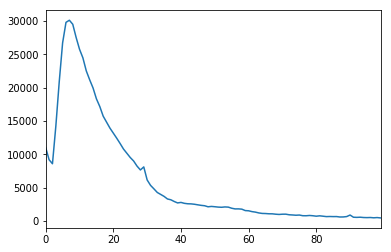

In [63]:
cycle_df['Trip Duration Minutes'].value_counts().sort_index().head(100).plot()

### Create Cycle DF Variants
The data was filtered based on Trip Durations:  
   * remove rides shorter than 2 minutes
   * include rides only shorter than 2 minutes
   * remove rides shorter than 75 minutes
   * include rides only longer than 75 minutes


In [64]:
cycle_df_no_0_2 = cycle_df.drop(cycle_df[
    cycle_df['Trip Duration Minutes'].isin([0,1,2])].index)

cycle_df_only_0_2 = cycle_df.drop(cycle_df[
    cycle_df['Trip Duration Minutes'] > 2].index)

cycle_df_less_75_min =  cycle_df.drop(cycle_df[
    cycle_df['Trip Duration Minutes'] > 75].index)

cycle_df_longer_75_min =  cycle_df.drop(cycle_df[
    cycle_df['Trip Duration Minutes'] < 75].index)



all_cycle_df = [cycle_df,
                cycle_df_no_0_2,
                cycle_df_only_0_2, 
                cycle_df_less_75_min, cycle_df_longer_75_min,
               ]


for df in all_cycle_df:
    print(df.shape)

(649231, 10)
(620432, 10)
(28799, 10)
(604383, 10)
(45758, 10)


## View Cycle DF variants Trip Duration in Minutes

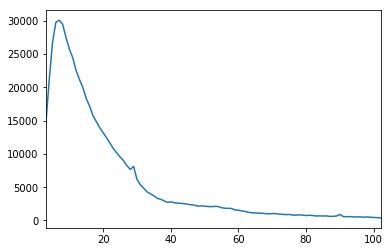

In [65]:
all_cycle_df[1]['Trip Duration Minutes'].value_counts().sort_index().head(100).plot()

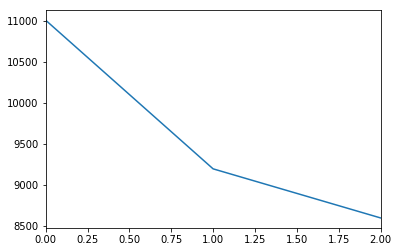

In [66]:
all_cycle_df[2]['Trip Duration Minutes'].value_counts().sort_index().head(100).plot()

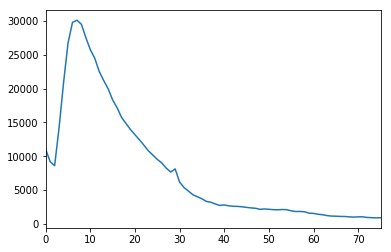

In [67]:
all_cycle_df[3]['Trip Duration Minutes'].value_counts().sort_index().head(100).plot()

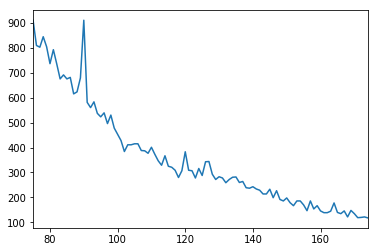

In [68]:
all_cycle_df[4]['Trip Duration Minutes'].value_counts().sort_index().head(100).plot()

## View Trip Duration by day of the week

In [69]:
for df in all_cycle_df:
    df['Checkout WeekDay'] = df['Checkout Date'].dt.day_name()
    

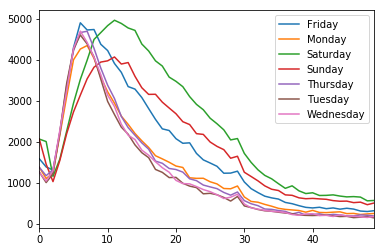

In [70]:
df = all_cycle_df[0]
cycle_weekdays = df.groupby('Checkout WeekDay')
for name,group in cycle_weekdays:
    group['Trip Duration Minutes'].value_counts().sort_index()\
    .head(50).plot(legend=True,label=name)

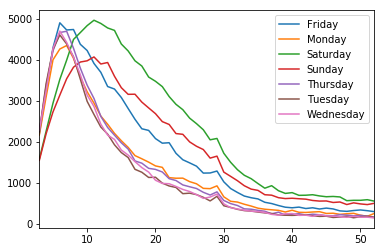

In [71]:
df = all_cycle_df[1]
cycle_weekdays = df.groupby('Checkout WeekDay')
for name,group in cycle_weekdays:
    group['Trip Duration Minutes'].value_counts().sort_index()\
    .head(50).plot(legend=True,label=name)

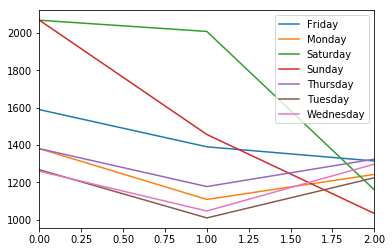

In [72]:
df = all_cycle_df[2]
cycle_weekdays = df.groupby('Checkout WeekDay')
for name,group in cycle_weekdays:
    group['Trip Duration Minutes'].value_counts().sort_index()\
    .head(50).plot(legend=True,label=name)

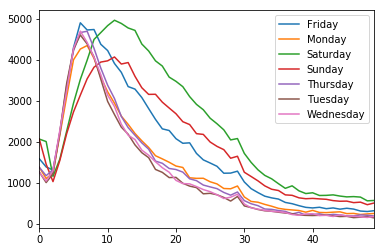

In [73]:
df = all_cycle_df[3]
cycle_weekdays = df.groupby('Checkout WeekDay')
for name,group in cycle_weekdays:
    group['Trip Duration Minutes'].value_counts().sort_index()\
    .head(50).plot(legend=True,label=name)

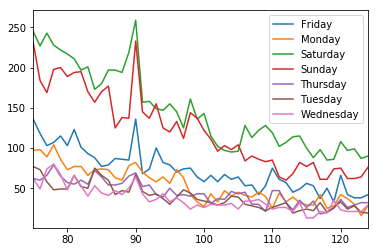

In [74]:
df = all_cycle_df[4]
cycle_weekdays = df.groupby('Checkout WeekDay')
for name,group in cycle_weekdays:
    group['Trip Duration Minutes'].value_counts().sort_index()\
    .head(50).plot(legend=True,label=name)

## Notes  
Trips are twice as long on Saturday and Sunday then all other days. (~11-12 min compared to ~6-7)  
The distribution of Friday Saturday and Sunday is right shifted compared to the 4 days.  
Monday-Thursday distributions are nearly identical.   

## View Time Duration by Month

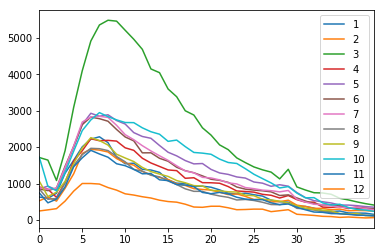

In [75]:
df = all_cycle_df[0]
cycle_months = df.groupby('Month')
for index,(name,group) in enumerate(cycle_months):
#     if 4 < index < 9 :
#         continue
#     elif index >12:
#         continue 
    group['Trip Duration Minutes'].value_counts().sort_index()\
    .head(40).plot(legend=True,label=name)

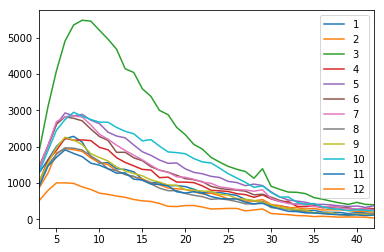

In [76]:
df = all_cycle_df[1]
cycle_months = df.groupby('Month')
for index,(name,group) in enumerate(cycle_months):
#     if 4 < index < 9 :
#         continue
#     elif index >12:
#         continue 
    group['Trip Duration Minutes'].value_counts().sort_index()\
    .head(40).plot(legend=True,label=name)

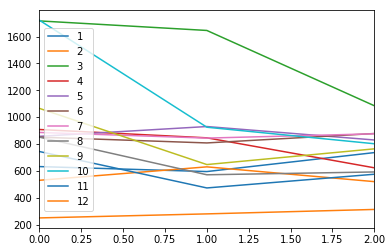

In [77]:
df = all_cycle_df[2]
cycle_months = df.groupby('Month')
for index,(name,group) in enumerate(cycle_months):
#     if 4 < index < 9 :
#         continue
#     elif index >12:
#         continue 
    group['Trip Duration Minutes'].value_counts().sort_index()\
    .head(40).plot(legend=True,label=name)

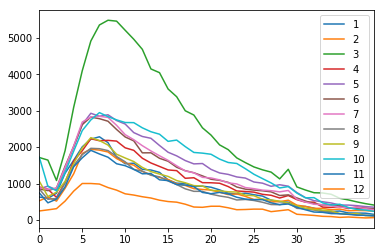

In [78]:
df = all_cycle_df[3]
cycle_months = df.groupby('Month')
for index,(name,group) in enumerate(cycle_months):
#     if 4 < index < 9 :
#         continue
#     elif index >12:
#         continue 
    group['Trip Duration Minutes'].value_counts().sort_index()\
    .head(40).plot(legend=True,label=name)

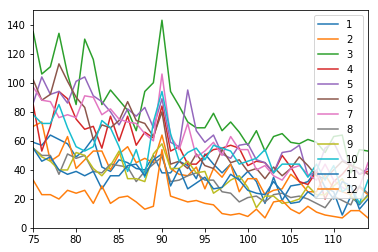

In [79]:
df = all_cycle_df[4]
cycle_months = df.groupby('Month')
for index,(name,group) in enumerate(cycle_months):
#     if 4 < index < 9 :
#         continue
#     elif index >12:
#         continue 
    group['Trip Duration Minutes'].value_counts().sort_index()\
    .head(40).plot(legend=True,label=name)

## Notes
March is the most popular month.  
October and May are tied for second but October trips length are a bit longer.  
December is the least popular month by far.  
June through September are practically identical.  
January, February, and April are about the same, with February being the lowest.  
February is about tied with November.  

Overall there are 4 tiers:  
1. March 
2. May and October
3. All months besides December
4. December

## View Checkout Time by Day of the Week

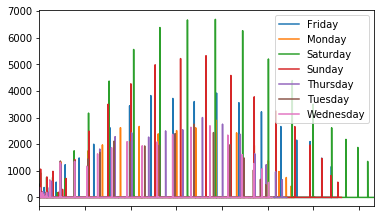

In [80]:
df = all_cycle_df[0]
cycle_weekdays = df.groupby('Checkout WeekDay')
for index,(name,group) in enumerate(cycle_weekdays):
#     if index not in [1,6]:
#         continue
    group['Checkout Time'].value_counts().sort_index()\
    .plot(legend=True,label=name)

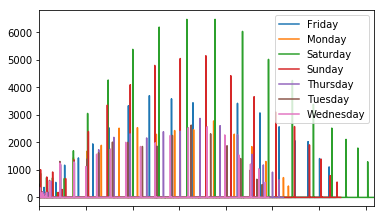

In [81]:
df = all_cycle_df[1]
cycle_weekdays = df.groupby('Checkout WeekDay')
for index,(name,group) in enumerate(cycle_weekdays):
#     if index not in [1,6]:
#         continue
    group['Checkout Time'].value_counts().sort_index()\
    .plot(legend=True,label=name)

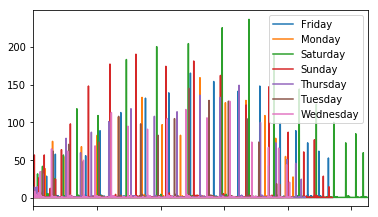

In [82]:
df = all_cycle_df[2]
cycle_weekdays = df.groupby('Checkout WeekDay')
for index,(name,group) in enumerate(cycle_weekdays):
#     if index not in [1,6]:
#         continue
    group['Checkout Time'].value_counts().sort_index()\
    .plot(legend=True,label=name)

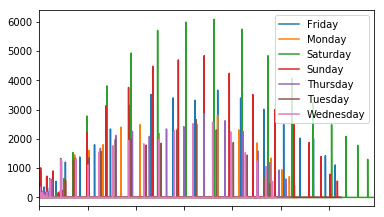

In [83]:
df = all_cycle_df[3]
cycle_weekdays = df.groupby('Checkout WeekDay')
for index,(name,group) in enumerate(cycle_weekdays):
#     if index not in [1,6]:
#         continue
    group['Checkout Time'].value_counts().sort_index()\
    .plot(legend=True,label=name)

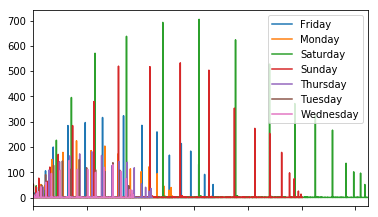

In [84]:
df = all_cycle_df[4]
cycle_weekdays = df.groupby('Checkout WeekDay')
for index,(name,group) in enumerate(cycle_weekdays):
#     if index not in [1,6]:
#         continue
    group['Checkout Time'].value_counts().sort_index()\
    .plot(legend=True,label=name)

## Notes
Majority trips between midnight and 3 am are on saturday and sunday.  
Thursday, Tuesday, Monday are about the same. Thursday is slightly taller in the afternoon.  
Tuesday and Wednesday are practically identical.   
Monday is slightly taller than Wednesday during peak hours.  

## Explore Checkout/Return Kiosks

In [85]:
df = all_cycle_df[1]

checkout_return_pairs = df.\
    groupby(['Checkout Kiosk','Return Kiosk']).size().reset_index()\
    .rename(columns={0:'counts'}) 

checkout_return_pairs = checkout_return_pairs\
    .sort_values('counts', ascending=False).reset_index()

# total_trips = checkout_return_pairs['counts'].sum()

# checkout_return_pairs['freq_%'] = checkout_return_pairs['counts']\
#     .map(lambda x: round(x/total_trips*100,4))


print("Shape of kiosk pair df: ",checkout_return_pairs.shape)


checkout_return_pairs.head(100)

Shape of kiosk pair df:  (5098, 4)


,index,Checkout Kiosk,Return Kiosk,counts
0,3949,Riverside @ S. Lamar,Riverside @ S. Lamar,7799
1,3574,Rainey St @ Cummings,Rainey St @ Cummings,4997
2,196,2nd & Congress,2nd & Congress,3681
3,1572,City Hall / Lavaca & 2nd,City Hall / Lavaca & 2nd,3422
4,4987,Zilker Park,Zilker Park,3226
5,5097,Zilker Park at Barton Springs & William Barton...,Zilker Park at Barton Springs & William Barton...,3125
6,3355,Pfluger Bridge @ W 2nd Street,Pfluger Bridge @ W 2nd Street,3077
7,1489,Capitol Station / Congress & 11th,Capitol Station / Congress & 11th,2929
8,3225,Palmer Auditorium,Palmer Auditorium,2571
9,993,Barton Springs & Riverside,Barton Springs & Riverside,2527


### Calculate Average and Mode for each Kiosk Pair

In [86]:
df = all_cycle_df[1]

groups = df.\
    groupby(['Checkout Kiosk','Return Kiosk'])


columns = ['Checkout Kiosk','Return Kiosk', 'Avg Trip Duration', 
          'Mode Trip Duration']
checkout_return_pairs_avg = pd.DataFrame(columns=columns)
for (checkout, checkin),group in groups:
    checkout_return_pairs_avg = checkout_return_pairs_avg\
        .append({col_name: value for col_name, value in 
                 zip(columns,[checkout,checkin,
                group['Trip Duration Minutes'].mean(),
                group['Trip Duration Minutes'].mode().max()])
                }, ignore_index=True)

checkout_return_pair_data = pd.merge(checkout_return_pairs, 
                                     checkout_return_pairs_avg,
                                     how='inner',
                                    left_on=['Checkout Kiosk',
                                             'Return Kiosk'],
                                    right_on=['Checkout Kiosk',
                                             'Return Kiosk'],
                                    )
checkout_return_pair_data.drop(columns='index', inplace=True)
#checkout_return_pair_data['Avg Trip Duration'].head(100).plot()
checkout_return_pair_data.head()

,Checkout Kiosk,Return Kiosk,counts,Avg Trip Duration,Mode Trip Duration
0,Riverside @ S. Lamar,Riverside @ S. Lamar,7799,52.916015,27
1,Rainey St @ Cummings,Rainey St @ Cummings,4997,63.470082,25
2,2nd & Congress,2nd & Congress,3681,75.861451,29
3,City Hall / Lavaca & 2nd,City Hall / Lavaca & 2nd,3422,74.004383,3
4,Zilker Park,Zilker Park,3226,59.846559,44


### Trend between kiosk pairs based on Time Duration of trip

### Kiosk pairs where the average trip was less than 15 minutes

In [87]:
checkout_return_pair_data[checkout_return_pair_data[
    'Avg Trip Duration'
] < 15].head(40)

,Checkout Kiosk,Return Kiosk,counts,Avg Trip Duration,Mode Trip Duration
11,5th & Bowie,4th & Congress,2429,8.991354,6
14,4th & Congress,5th & Bowie,2251,11.327410,6
16,5th & Bowie,City Hall / Lavaca & 2nd,2124,11.005179,5
18,3rd & West,City Hall / Lavaca & 2nd,1855,8.933693,4
20,Convention Center / 4th St. @ MetroRail,City Hall / Lavaca & 2nd,1790,13.854749,5
23,City Hall / Lavaca & 2nd,5th & Bowie,1666,11.029412,5
24,Republic Square @ Guadalupe & 4th St.,5th & Bowie,1653,7.770115,4
26,5th & Bowie,Convention Center / 4th St. @ MetroRail,1509,13.652750,8
27,3rd & West,4th & Congress,1499,9.168779,5
35,5th & Bowie,2nd & Congress,1318,12.780728,7


### Kiosk pairs where the average trip was longer than 25 minutes

In [88]:
checkout_return_pair_data[checkout_return_pair_data[
    'Avg Trip Duration'
] > 25].head(40)

,Checkout Kiosk,Return Kiosk,counts,Avg Trip Duration,Mode Trip Duration
0,Riverside @ S. Lamar,Riverside @ S. Lamar,7799,52.916015,27
1,Rainey St @ Cummings,Rainey St @ Cummings,4997,63.470082,25
2,2nd & Congress,2nd & Congress,3681,75.861451,29
3,City Hall / Lavaca & 2nd,City Hall / Lavaca & 2nd,3422,74.004383,3
4,Zilker Park,Zilker Park,3226,59.846559,44
5,Zilker Park at Barton Springs & William Barton...,Zilker Park at Barton Springs & William Barton...,3125,53.919360,24
6,Pfluger Bridge @ W 2nd Street,Pfluger Bridge @ W 2nd Street,3077,57.786155,27
7,Capitol Station / Congress & 11th,Capitol Station / Congress & 11th,2929,54.652783,29
8,Palmer Auditorium,Palmer Auditorium,2571,64.497083,11
9,Barton Springs & Riverside,Barton Springs & Riverside,2527,77.552434,58


## Note
Most of the long trip durations are returned to the station they were checked out of.

All of the short trips are returned at a different station.

## Remove nontrip Kiosk Pairs

In [89]:
rm_kiosk = ['Stolen','Missing',
              'Main Shop','Repair Shop', 'Shop',
              'Customer Service','Main Office',]
cleaned_checkout_return_pair_data = checkout_return_pair_data[
    ~checkout_return_pair_data['Return Kiosk'].isin(rm_kiosk) &
    ~checkout_return_pair_data['Checkout Kiosk'].isin(rm_kiosk)
]


# cleaned_checkout_return_pair_data[
#     cleaned_checkout_return_pair_data['counts'] > 100
# ]

bad_checkout_return_pair_data = checkout_return_pair_data[
    checkout_return_pair_data['Return Kiosk'].isin(rm_kiosk) |
    checkout_return_pair_data['Checkout Kiosk'].isin(rm_kiosk)
]

bad_checkout_return_pair_data.sort_values(
    'counts', ascending=False, inplace=True
)

print('Not Real Trips: ',bad_checkout_return_pair_data.counts.sum())

bad_checkout_return_pair_data.head(10)

Not Real Trips:  968


/Users/Danny/.virtualenvs/CS_329E/lib/python3.7/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,Checkout Kiosk,Return Kiosk,counts,Avg Trip Duration,Mode Trip Duration
1683,East 11th St. & San Marcos,Main Office,76,28.921053,29
1709,Main Office,East 11th St. & San Marcos,74,7.702703,6
2137,State Capitol Visitors Garage @ San Jacinto & ...,Main Office,49,15.551020,4
2456,Main Office,State Capitol Visitors Garage @ San Jacinto & ...,36,6.777778,3
3261,5th & Bowie,Customer Service,16,730.875000,29
3284,East 11th St. & San Marcos,Repair Shop,16,84.125000,12
3394,Main Office,Barton Springs & Riverside,14,11.214286,14
3493,Main Office,Main Office,13,63.000000,29
3496,17th & Guadalupe,Main Office,13,11.461538,6
3470,Convention Center / 4th St. @ MetroRail,Customer Service,13,156.692308,29


## Notes
968 trips are not real. 681 come from not having a real Return Kiosk.  
These are bikes that were checked out and were not checked back in for another customer to use. 

## Compare cycle dates to weather dates

In [90]:
print('weather dates:', len(weather_df['Date'].unique()))
print('cycle dates:  ', len(cycle_df['Checkout Date'].unique()))

missing_dates = pd.date_range(start = '2013-12-21', end = '2017-07-31' )\
    .difference(cycle_df['Checkout Date'])

print(len(missing_dates))
missing_dates

weather dates: 1319
cycle dates:   1257
62


DatetimeIndex(['2014-08-31', '2016-04-01', '2016-04-02', '2016-04-03',
               '2016-04-04', '2016-04-05', '2016-04-06', '2016-04-07',
               '2016-04-08', '2016-04-09', '2016-04-10', '2016-04-11',
               '2016-04-12', '2016-04-13', '2016-04-14', '2016-04-15',
               '2016-04-16', '2016-04-17', '2016-04-18', '2016-04-19',
               '2016-04-20', '2016-04-21', '2016-04-22', '2016-04-23',
               '2016-04-24', '2016-04-25', '2016-04-26', '2016-04-27',
               '2016-04-28', '2016-04-29', '2016-04-30', '2016-12-01',
               '2016-12-02', '2016-12-03', '2016-12-04', '2016-12-05',
               '2016-12-06', '2016-12-07', '2016-12-08', '2016-12-09',
               '2016-12-10', '2016-12-11', '2016-12-12', '2016-12-13',
               '2016-12-14', '2016-12-15', '2016-12-16', '2016-12-17',
               '2016-12-18', '2016-12-19', '2016-12-20', '2016-12-21',
               '2016-12-22', '2016-12-23', '2016-12-24', '2016-12-25',
      

## Notes
It seems that the entire month of April and Decemeber for 2016 we have no data.   
The one other date is August 31, 2014.  
These rows were dropped from the weather csv. 

## Cleaning Final DF

In [91]:
new_weather_df = weather_df[~weather_df['Date'].isin(missing_dates)]
len(new_weather_df['Date'].unique())


1257

In [92]:
df = all_cycle_df[1]
print(df.shape)

cleaned_df = df[
    ~df['Checkout Kiosk'].isin(rm_kiosk) &
    ~df['Return Kiosk'].isin(rm_kiosk)
]

cleaned_df.shape



(620432, 11)


(619464, 11)

## Creating CSV for feature engineering

In [93]:
cleaned_df.to_csv('./data/cleaned_final_b_cycle_data.csv', 
                  index=False)

new_weather_df.to_csv('./data/cleaned_austin_weather.csv',
                     index=False)